Understanding changes in episodes using a time window (~ 5 years). Want to see if the documents are "stable" over time otherwise our analysis cannot be generalized beyond TAL.

In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [24]:
file = '../tal-scrape/total_trans_normalized.csv'
tal_df = pd.read_csv(file)

In [111]:
tal_df['tokenized_text'] = tal_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))

In [112]:
tal_df['no_lemma_normalized_tokens'] = tal_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [31]:
def group(row):
    if row['year'] < 2000:
        return 1
    elif row['year'] < 2005:
        return 2
    elif row['year'] < 2010:
        return 3
    elif row['year'] < 2015:
        return 4
    else:
        return 5

In [32]:
tal_df['group'] = tal_df.apply(lambda x: group(x), axis=1)

In [53]:
tal_df.columns

Index(['ep_num', 'ep_title', 'year', 'url', 'act_name', 'text',
       'tokenized_sents', 'no_lemma_normalized_sents', 'normalized_sents',
       'tokenized_text', 'normalized_tokens', 'no_lemma_normalized_tokens',
       'TaggedAbstracts', 'group'],
      dtype='object')

Method 1: Build Doc2Vec model using all text from all episodes. Groups 2-5 are very similar, group 1 ranges from neutral to slightly negative

In [114]:
grouped = tal_df.groupby('group').agg({'tokenized_sents':'sum', 'no_lemma_normalized_sents': 'sum',
                                      'normalized_sents':'sum','tokenized_text':'sum',
                                      'normalized_tokens':'sum','no_lemma_normalized_tokens':'sum'}).reset_index()

In [62]:
grouped

,group,tokenized_sents,no_lemma_normalized_sents,normalized_sents,tokenized_text,normalized_tokens,no_lemma_normalized_tokens
0,1,"[['This', 'is', 'Your', 'Radio', 'Playhouse'],...","[['radio', 'playhouse'], ['m', 'ira', 'glass']...","[['radio', 'playhouse'], ['be', 'ira', 'glass'...","['This', 'is', 'Your', 'Radio', 'Playhouse', '...","['radio', 'playhouse', 'be', 'ira', 'glass', '...","['radio', 'playhouse', 'm', 'ira', 'glass', 'o..."
1,2,"[['Act', 'Four', 'Looking', 'For', 'Love', 'in...","[['act', 'looking', 'love', 'wrong', 'places']...","[['act', 'look', 'love', 'wrong', 'place'], ['...","['Act', 'Four', 'Looking', 'For', 'Love', 'in'...","['act', 'look', 'love', 'wrong', 'place', 'obe...","['act', 'looking', 'love', 'wrong', 'places', ..."
2,3,"[['OK', 'here', ""'s"", 'a', 'joke', 'that', 'US...","[['ok', 'joke', 'servicemen', 'iraq', 'love'],...","[['okay', 'joke', 'serviceman', 'iraq', 'love'...","['OK', 'here', ""'s"", 'a', 'joke', 'that', 'US'...","['okay', 'joke', 'serviceman', 'iraq', 'love',...","['ok', 'joke', 'servicemen', 'iraq', 'love', '..."
3,4,"[['From', 'WBEZ', 'Chicago', 'it', ""'s"", 'This...","[['wbez', 'chicago', 'american', 'life', 'dist...","[['wbez', 'chicago', 'american', 'life', 'dist...","['From', 'WBEZ', 'Chicago', 'it', ""'s"", 'This'...","['wbez', 'chicago', 'american', 'life', 'distr...","['wbez', 'chicago', 'american', 'life', 'distr..."
4,5,"[['Alix', 'used', 'to', 'work', 'here', 'at', ...","[['alix', 'work', 'program'], ['lulu', 'worked...","[['alix', 'work', 'program'], ['lulu', 'work',...","['Alix', 'used', 'to', 'work', 'here', 'at', '...","['alix', 'work', 'program', 'lulu', 'work', 'r...","['alix', 'work', 'program', 'lulu', 'worked', ..."


In [28]:
keywords = [
    'happy', 'sad', 'excited', 'excite', 'fear', 'lonely', 'loneliness', 'ashamed', 'shame', 'embarrassed', 
    'embarrass', 'hate', 'love', 'anger', 'upset', 'elated', 'tired', 'lazy', 'laziness', 'dread', 'hope',
    'believe', 'belief', 'perspective', 'opinion', 'thought', 'think', 'attitude', 'judgement',
    'single', 'divorce', 'divorced', 'family', 'brother', 'sister', 'children', 'child', 'wedding', 'married', 'marriage', 
    'boyfriend', 'girlfriend', 'partner', 'love',
    'self', 'myself', 'appearance', 'looks', 'confidence', 'perception', 'perceive', 'gay', 'lesbian', 
    'asian', 'hispanic', 'black', 'white', 'ethnic', 'ethnicity', 'american', 'disabled', 'queer', 'exotic'
]

In [115]:
taggedDocs = []
for index, row in grouped.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['no_lemma_normalized_tokens']]
    docKeywords.append(row['group'])
    #docKeywords.append(row['ep_title']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['no_lemma_normalized_tokens'], tags = docKeywords))
grouped['TaggedAbstracts'] = taggedDocs

In [116]:
talD2V = gensim.models.doc2vec.Doc2Vec(grouped['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

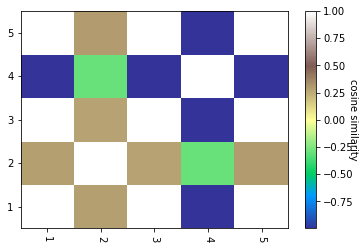

In [117]:
# similarities between groups
targetDocs = grouped['group']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = talD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, talD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [118]:
talD2V.save('talD2V_alltext')

Method 2: Build Doc2Vec model using only prologues from all episodes. Groups are even more similar than with all text except, notably, for groups 1 and 3.

In [119]:
p = tal_df[tal_df.act_name == 'Prologue']

In [120]:
p_grouped = p.groupby('group').agg({'no_lemma_normalized_tokens':'sum'}).reset_index()

In [121]:
taggedDocs = []
for index, row in p_grouped.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['no_lemma_normalized_tokens']]
    docKeywords.append(row['group'])
    #docKeywords.append(row['ep_title']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['no_lemma_normalized_tokens'], tags = docKeywords))
p_grouped['TaggedAbstracts'] = taggedDocs

In [122]:
talD2V = gensim.models.doc2vec.Doc2Vec(p_grouped['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

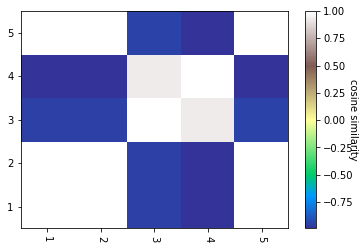

In [123]:
# similarities between groups
targetDocs = p_grouped['group']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = talD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, talD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [124]:
talD2V.save('talD2V_prologue')

Method 3: Project words from groups into existing vector space (maybe NYT W2V?). 

- Plot each of the group words into word2vec space
    - maybe should reduce the number of words using TFIDF?
- Get the centroid of each group
- And then compare the final ~5 centroids
   - how to do the actual comparison? would be hard to visualize

When plotting the reduced dimensions of each groups words onto NYT - > see they all overlap! not a lot of movement

In [94]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../Content-Analysis-2020/data/nytimes_cbow.reduced.txt')

In [140]:
g1TargetWords = p_grouped['no_lemma_normalized_tokens'].iloc[2-1]

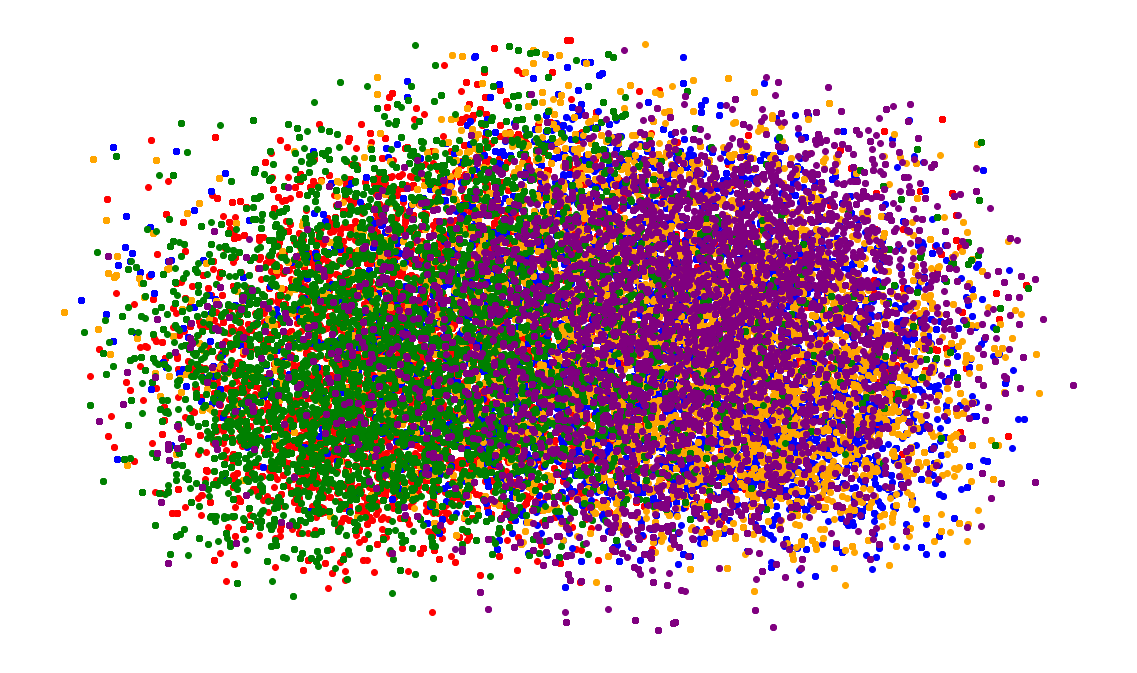

In [145]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

c_dict = {'1':'red',
         '2':'blue',
         '3': 'orange',
         '4': 'green',
         '5': 'purple'}

for i in p_grouped['group']:
    TargetWords = p_grouped['no_lemma_normalized_tokens'].iloc[i-1]
    # create word matrix
    wordsSubMatrix = []
    for word in TargetWords:
        #print(word)
        try:
            wordsSubMatrix.append(nytimes_model[word])
        except Exception as e: 
            continue
    wordsSubMatrix = np.array(wordsSubMatrix)
    # reduce 
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA = pcaWords.transform(wordsSubMatrix)
    plt.scatter(reducedPCA[:, 0], reducedPCA[:, 1], alpha = 1, color=c_dict[str(i)])

plt.xticks(())
plt.yticks(())
plt.show()

In [129]:
wordsSubMatrix = []
for word in g1TargetWords:
    #print(word)
    try:
        wordsSubMatrix.append(nytimes_model[word])
    except Exception as e: 
        continue
wordsSubMatrix = np.array(wordsSubMatrix)

In [143]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)

In [134]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

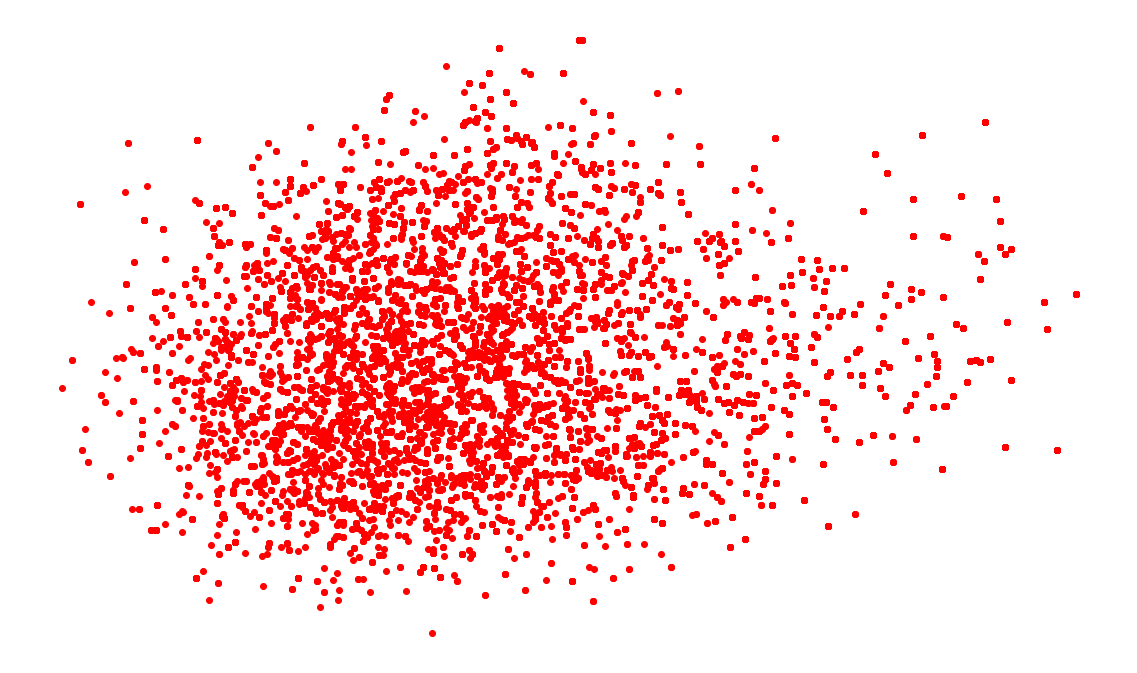

In [144]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_dataNYT[:, 0], reducedPCA_dataNYT[:, 1], alpha = 1, color='red') #Making the points invisible
#plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 1, color='orange')
# for i, word in enumerate(tnytTargetWords):
#     ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()